<a href="https://colab.research.google.com/github/rwarnung/datacrunch-notebooks/blob/master/dcrunch_R_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Data crunch example R script**


---


author: sweet-richard

date: Jan 30, 2022

required packages:

*   `tidyverse` for data handling
*   `feather` for efficient loading of data
*   `xgboost` for predictive modelling
*   `httr`  for the automatic upload.



In [9]:
library(tidyverse)
library(feather)

First, we set some **parameters**.


*   `is_download` controls whether you want to download data or just read prevously downloaded data
*   `is_upload` set this to TRUE for automatic upload.
*   `nrounds` is a parameter for `xgboost` that we set to 100 for illustration. You might want to adjust the paramters of xgboost.











In [18]:
#' ## Parameters
file_name_train = "train_data.feather"
file_name_test ="test_data.feather"
is_download = TRUE # set this to true to download new data or to FALSE to load data in feather format
is_upload = FALSE # set this to true to upload a submission
nrounds = 300 # you might want to adjust this one and other parameters of xgboost

In the **functions** section we defined the correlation measure that we use to measure performance.

In [11]:
#' ## Functions
#+ 

getCorrMeasure = function(actual, predicted) {
  cor_measure = cor(actual, predicted, method="spearman")
  return(cor_measure)
}

Now, we either **download** the current data from the servers or load them in feather format. Furthermore, we define the features that we actually want to use. In this illustration we use all of them but `id` and `Moons`.

In [12]:
#' ## Download data
#' after the download, data is stored in feather format to be read on demand quickly. Data is stored in integer format to save memory.
#+

if( is_download ) {
  
  cat("\n start  download")
  train_datalink_X = 'https://tournament.datacrunch.com/data/X_train.csv'  
  train_datalink_y = 'https://tournament.datacrunch.com/data/y_train.csv' 
  hackathon_data_link = 'https://tournament.datacrunch.com/data/X_test.csv' 
  
  train_dataX = read_csv(url(train_datalink_X))
  train_dataY = read_csv(url(train_datalink_y))
  test_data  = read_csv(url(hackathon_data_link))
  
  train_data = 
    bind_cols( train_dataX, train_dataY)
  
  train_data = train_data %>% mutate_at(vars(starts_with("feature_")), list(~as.integer(.*100)))
  feather::write_feather(train_data, path = paste0("./", file_name_train))
  
  test_data = test_data %>% mutate_at(vars(starts_with("feature_")), list(~as.integer(.*100)))
  feather::write_feather(test_data, path = paste0("./", file_name_test))
  
  names(train_data)
  
  nrow(train_data)
  nrow(test_data)
  
  cat("\n data is downloaded")
} else {
  train_data = feather::read_feather(path = paste0("./", file_name_train))
  test_data =  feather::read_feather(path = paste0("./", file_name_test))
}

## set vars used for modelling 
model_vars = setdiff(names(test_data), c("id","Moons"))


 start  download

Rows: 620386 Columns: 51

── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): id
dbl (50): Moons, Feature_1, Feature_2, Feature_3, Feature_4, Feature_5, Feat...


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

Rows: 620386 Columns: 3

── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (3): target_r, target_g, target_b


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

Rows: 347878 Columns: 51

── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): id
dbl (50): Moons, Feature_1, Feature_2, Feature_3, Feature_4, Feature_5, Feat...


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column ty


 data is downloaded

Next we fit our go-to algorithm **xgboost** with mainly default parameters, only `eta` and `max_depth` are set.

In [13]:
#' ## Fit xgboost
#+ cache = TRUE

library(xgboost, warn.conflicts = FALSE)

# custom loss function for eval  
corrmeasure <- function(preds, dtrain) {
  labels <- getinfo(dtrain, "label")
  corrm <- as.numeric(cor(labels, preds, method="spearman"))
  return(list(metric = "corr", value = corrm))
}
  
eval_metric_string =  "rmse"
my_objective = "reg:squarederror"

tree.params = list(
  booster = "gbtree", eta = 0.01, max_depth = 5,
  tree_method = "hist", #  tree_method = "auto",
  objective = my_objective)

cat("\n starting xgboost \n")



 starting xgboost 


**First target** `target_r`

In [19]:
# first target target_r then g and b
################
current_target = "target_r"
  
dtrain = xgb.DMatrix(train_data %>% select(one_of(model_vars)) %>% as.matrix(), label = train_data %>% select(one_of(current_target))  %>% as.matrix())
  
xgb.model.tree = xgb.train(data = dtrain,  
                           params = tree.params, nrounds = nrounds, verbose = 1, 
                           print_every_n = 50L, eval_metric = corrmeasure) 
  
xgboost_tree_train_pred1 = predict(xgb.model.tree, train_data %>% select(one_of(model_vars)) %>% as.matrix())
xgboost_tree_live_pred1 = predict(xgb.model.tree, test_data %>% select(one_of(model_vars)) %>% as.matrix())
  
cor_train = getCorrMeasure(train_data %>% select(one_of(current_target)), xgboost_tree_train_pred1)
  
cat("\n : metric: ", eval_metric_string, "\n")
print(paste0("Corrm on train: ", round(cor_train,4)))

print(paste("xgboost", current_target, "ready"))


 : metric:  rmse 
[1] "Corrm on train: 0.0867"
[1] "xgboost target_r ready"


**Second target** `target_g`

In [20]:
# second target target_g
################
current_target = "target_g"
  
dtrain = xgb.DMatrix(train_data %>% select(one_of(model_vars)) %>% as.matrix(), label = train_data %>% select(one_of(current_target))  %>% as.matrix())

xgb.model.tree = xgb.train(data = dtrain,  
                           params = tree.params, nrounds = nrounds, verbose = 1, 
                           print_every_n = 50L, eval_metric = corrmeasure) 

xgboost_tree_train_pred2 = predict(xgb.model.tree, train_data %>% select(one_of(model_vars)) %>% as.matrix())
xgboost_tree_live_pred2 = predict(xgb.model.tree, test_data %>% select(one_of(model_vars)) %>% as.matrix())

cor_train = getCorrMeasure(train_data %>% select(one_of(current_target)), xgboost_tree_train_pred2)

cat("\n : metric: ", eval_metric_string, "\n")
print(paste0("Corrm on train: ", round(cor_train,4)))

print(paste("xgboost", current_target, "ready"))


 : metric:  rmse 
[1] "Corrm on train: 0.1099"
[1] "xgboost target_g ready"


**Third target** `target_b`

In [21]:
# third target target_b
################
current_target = "target_b"

dtrain = xgb.DMatrix(train_data %>% select(one_of(model_vars)) %>% as.matrix(), label = train_data %>% select(one_of(current_target))  %>% as.matrix())

xgb.model.tree = xgb.train(data = dtrain,  
                           params = tree.params, nrounds = nrounds, verbose = 1, 
                           print_every_n = 50L, eval_metric = corrmeasure) 

xgboost_tree_train_pred3 = predict(xgb.model.tree, train_data %>% select(one_of(model_vars)) %>% as.matrix())
xgboost_tree_live_pred3 = predict(xgb.model.tree, test_data %>% select(one_of(model_vars)) %>% as.matrix())

cor_train = getCorrMeasure(train_data %>% select(one_of(current_target)), xgboost_tree_train_pred3)

cat("\n : metric: ", eval_metric_string, "\n")
print(paste0("Corrm on train: ", round(cor_train,4)))

print(paste("xgboost", current_target, "ready"))


 : metric:  rmse 
[1] "Corrm on train: 0.1232"
[1] "xgboost target_b ready"


Then we produce simply histogram plots to see whether the predictions are plausible and prepare a **submission file**:

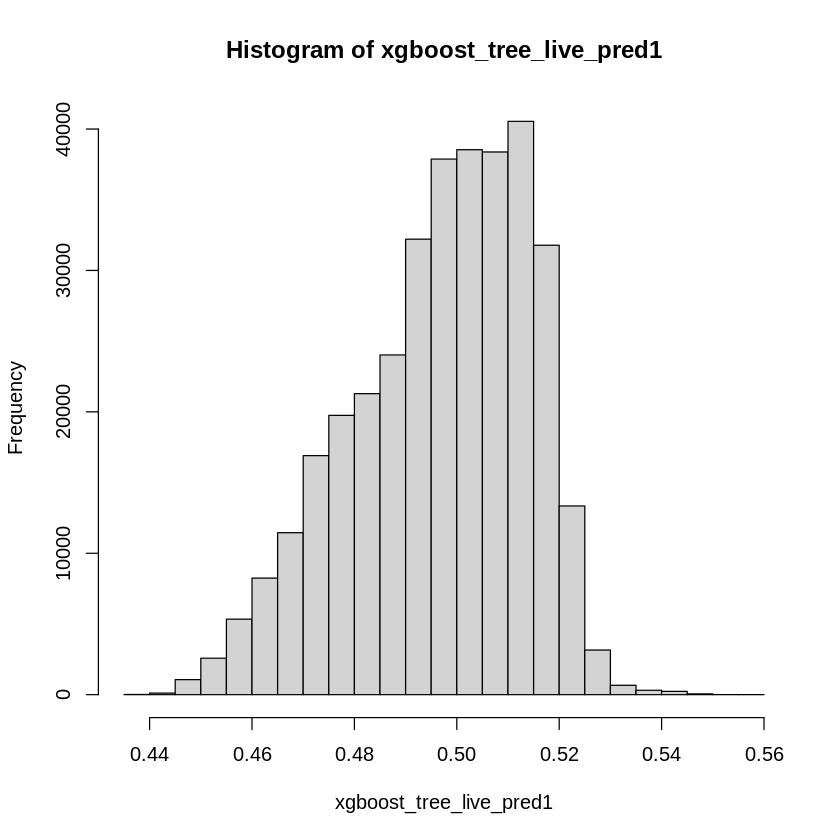

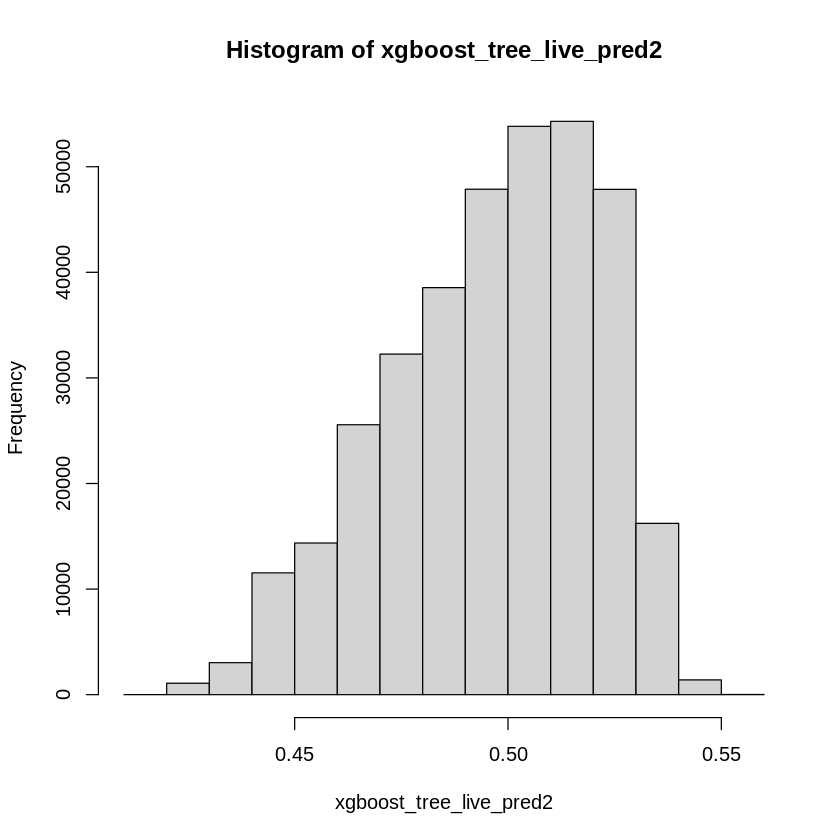

[1] 347878


 submission file written

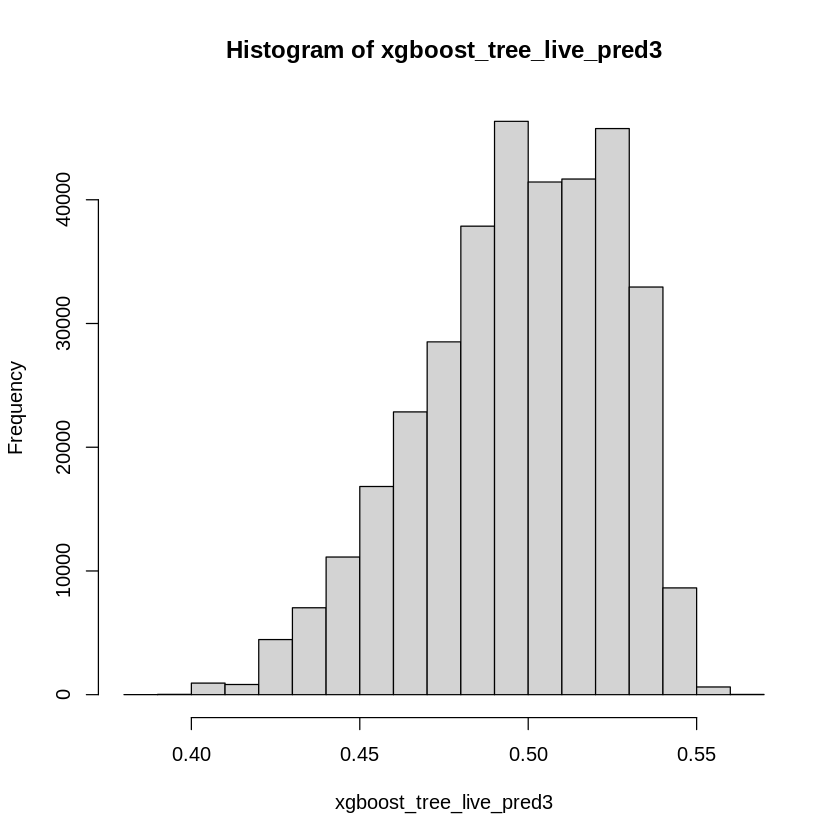

In [23]:
#' ## Submission
#' simple histograms to check the submissions
#+
hist(xgboost_tree_live_pred1)
hist(xgboost_tree_live_pred2)
hist(xgboost_tree_live_pred3)
  
#' create submission file
#+
sub_df = tibble(target_r = xgboost_tree_live_pred1, 
                target_g = xgboost_tree_live_pred2, 
                target_b = xgboost_tree_live_pred3)
  
file_name_submission = paste0("gbTree_", gsub("-","",Sys.Date()), ".csv")

sub_df %>% readr::write_csv(file = paste0("./", file_name_submission))
nrow(sub_df)

cat("\n submission file written")

Finally, we can **automatically upload** the file to the server:

In [ ]:
#' ## Upload submission
#+
if( is_upload ) {
  library(httr)
  
  API_KEY = "YourKeyHere"
  
  response <- POST(
    url = "https://tournament.crunchdao.com/api/v2/submissions",
    query = list(apiKey = API_KEY),
    body = list(
      file = upload_file(path = paste0("./", file_name_submission))
    ),
    encode = c("multipart")
  );
  
  status <- status_code(response)
  
  if (status == 200) {
    print("Submission submitted :)")
  } else if (status == 400) {
    print("ERR: The file must not be empty")
    print("You have send a empty file.")
  } else if (status == 401) {
    print("ERR: Your email hasn't been verified")
    print("Please verify your email or contact a cruncher.")
  } else if (status == 403) {
    print("ERR: Not authentified")
    print("Is the API Key valid?")
  } else if (status == 404) {
    print("ERR: Unknown API Key")
    print("You should check that the provided API key is valid and is the same as the one you've received by email.")
  } else if (status == 409) {
    print("ERR: Duplicate submission")
    print("Your work has already been submitted with the same exact results, if you think that this a false positive, contact a cruncher.")
    print("MD5 collision probability: 1/2^128 (source: https://stackoverflow.com/a/288519/7292958)")
  } else if (status == 422) {
    print("ERR: API Key is missing or empty")
    print("Did you forget to fill the API_KEY variable?")
  } else if (status == 423) {
    print("ERR: Submissions are close")
    print("You can only submit during rounds eg: Friday 7pm GMT+1 to Sunday midnight GMT+1.")
    print("Or the server is currently crunching the submitted files, please wait some time before retrying.")
  } else if (status == 423) {
    print("ERR: Too many submissions")
  } else {
    content <- httr::content(response)
    print("ERR: Server returned: " + toString(status))
    print("Ouch! It seems that we were not expecting this kind of result from the server, if the probleme persist, contact a cruncher.")
    print(paste("Message:", content$message, sep=" "))
  }
  
  # DEVELOPER WARNING:
  # THE API ERROR CODE WILL BE HANDLER DIFFERENTLY IN A NEAR FUTURE!
  # PLEASE STAY UPDATED BY JOINING THE DISCORD (https://discord.gg/veAtzsYn3M) AND READING THE NEWSLETTER EMAIL
}